In [1]:
using JuMP, Cbc, Clp, Random, Statistics, Plots

In [2]:
N = collect(50:50:1000)
K = collect(50:50:1000)
M = 10

10

Confidence Interval for Ni=50: [-1366.5711617436393,-1268.7088382563604]
Confidence Interval for Ni=100: [-1364.3982341403494,-1297.0017658596512]
Confidence Interval for Ni=150: [-1330.916697139314,-1287.4033028606852]
Confidence Interval for Ni=200: [-1331.2920148707253,-1287.6279851292752]
Confidence Interval for Ni=250: [-1320.5346495423057,-1289.6173504576943]
Confidence Interval for Ni=300: [-1324.9228516416122,-1298.583815025054]
Confidence Interval for Ni=350: [-1322.101411431392,-1288.2528742828931]
Confidence Interval for Ni=400: [-1327.8315021914493,-1297.2484978085502]
Confidence Interval for Ni=450: [-1335.8113031693395,-1306.335363497328]
Confidence Interval for Ni=500: [-1323.2607128020002,-1286.8352871979985]
Confidence Interval for Ni=550: [-1333.7674099400592,-1294.0471355144855]
Confidence Interval for Ni=600: [-1325.8181036221774,-1301.6752297111568]
Confidence Interval for Ni=650: [-1322.4922930407101,-1297.0553992669752]
Confidence Interval for Ni=700: [-1317.1046

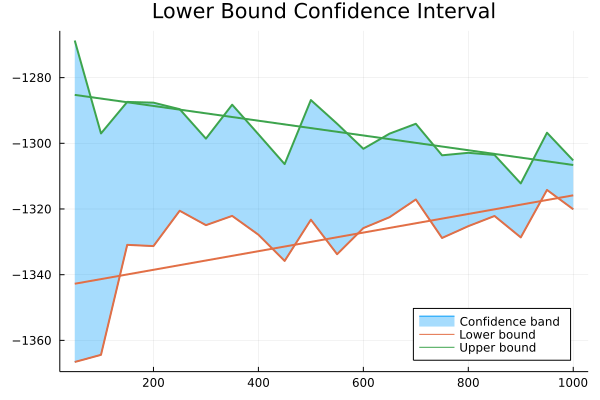


(process:17284): GLib-GIO-WARNING **: 13:18:47.055: Unexpectedly, UWP app `38526MediaLife.ZipPlus_2.0.4.0_x86__1crh1k73ty8mg' (AUMId `38526MediaLife.ZipPlus_1crh1k73ty8mg!ZipExtractor') supports 89 extensions but has no verbs


In [3]:
LB_left_Dict = Dict{Int, Float64}();
LB_right_Dict = Dict{Int, Float64}();
x_Dict =  Dict{Int, Vector{Float64}}();
for Ni in N    
    obj_value_list = []
    x_list = []
    for i=1:M    
        ξ = rand(50:150,Ni)
        master = Model(Clp.Optimizer)
        set_optimizer_attribute(master, "LogLevel",0)
        @variables(master,begin
            x ≥ 0
            y[1:Ni] ≥ 0
            w[1:Ni] ≥ 0
        end)
        @constraints(master,begin
            ct1[s=1:Ni], y[s] ≤ ξ[s]
            ct2[s=1:Ni], y[s] + w[s] ≤ x
        end)
        @objective(master, Min, 10*x + (1/Ni)*sum(-25*y[s] - 5*w[s] for s in 1:Ni))
        optimize!(master)
        append!(x_list,value(x))
        append!(obj_value_list, objective_value(master))
    end

    V̄=sum(obj_value_list)/M
    LB_left = V̄ - 1.96*std(obj_value_list)/sqrt(M)
    LB_right = V̄ + 1.96*std(obj_value_list)/sqrt(M)
    push!(LB_left_Dict,Ni =>LB_left)
    push!(LB_right_Dict,Ni =>LB_right)
    push!(x_Dict, Ni => x_list)
    println("Confidence Interval for Ni=$(Ni): [$(LB_left),$(LB_right)]")
end
# println(sort(x_Dict))
# println(LB_left_Dict)
# println(LB_right_Dict)

u = x-> LB_right_Dict[x]
plot(x=N,LB_left_Dict, fillrange=u,fillalpha = 0.35,label = "Confidence band", legend = :bottomright, title = "Lower Bound Confidence Interval")
plot!(x=N,LB_left_Dict, smooth=true, label = "Lower bound",lw = 2)
plot!(x=N,LB_right_Dict, smooth=true, label = "Upper bound",lw = 2)

In [4]:
obj_value_list = []
UB_right_Dict = Dict{Float64, Float64}();
for x̂ in x_Dict[1000]
    Ki=1000
    for i=1:M    
        ξ = rand(50:150,Ki)
        UB_model = Model(Clp.Optimizer)
        set_optimizer_attribute(UB_model, "LogLevel",0)
        @variables(UB_model,begin
            y[1:Ki] ≥ 0
            w[1:Ki] ≥ 0
        end)
        @constraints(UB_model,begin
            ct1[s=1:Ki], y[s] ≤ ξ[s]
            ct2[s=1:Ki], y[s] + w[s] ≤ x̂
        end)
        @objective(UB_model, Min, 10*x̂ + (1/Ki)*sum(-25*y[s] - 5*w[s] for s in 1:Ki))
        optimize!(UB_model)
        append!(obj_value_list, objective_value(UB_model))
    end
    V̄=sum(obj_value_list)/M
    UB_right = V̄ + 1.96*std(obj_value_list)/sqrt(M)
    push!(UB_right_Dict,x̂ =>UB_right)
end

x_chosen = reduce((x, y) -> UB_right_Dict[x] ≤ UB_right_Dict[y] ? x : y, keys(UB_right_Dict)) # x̄ que gera a menor entre as M cotas superiores

println(x_chosen)
println(UB_right_Dict)

128.0
Dict(128.000000000001 => -2588.681796692153, 124.00000000000298 => -11750.757049953938, 124.00000000000895 => -10444.28660214205, 125.00000000000199 => -5212.723823476734, 126.00000000000199 => -9141.623767640029, 124.00000000000995 => -6517.498913229965, 123.00000000000398 => -7830.224570756921, 128.0 => -13059.152133058215, 124.00000000000199 => -1288.9395194563613)


Confidence Interval for Ki=50: [-1412.0406410888866,-1293.5593589111143]
Confidence Interval for Ki=100: [-1325.9469714436711,-1272.89302855633]
Confidence Interval for Ki=150: [-1337.5101525536359,-1293.1031807796965]
Confidence Interval for Ki=200: [-1317.7044357770242,-1287.4155642229744]
Confidence Interval for Ki=250: [-1330.2255248863682,-1295.262475113632]
Confidence Interval for Ki=300: [-1323.4994456358706,-1289.180554364132]
Confidence Interval for Ki=350: [-1333.0974974039912,-1298.7882168817234]
Confidence Interval for Ki=400: [-1340.4770984095437,-1298.542901590454]
Confidence Interval for Ki=450: [-1326.36235729453,-1298.8109760388063]
Confidence Interval for Ki=500: [-1321.7255575103802,-1278.0504424896324]
Confidence Interval for Ki=550: [-1324.2129182380895,-1292.885263580069]
Confidence Interval for Ki=600: [-1327.656131041698,-1304.1305356249698]
Confidence Interval for Ki=650: [-1325.667854009281,-1289.944453683023]
Confidence Interval for Ki=700: [-1316.22190943277

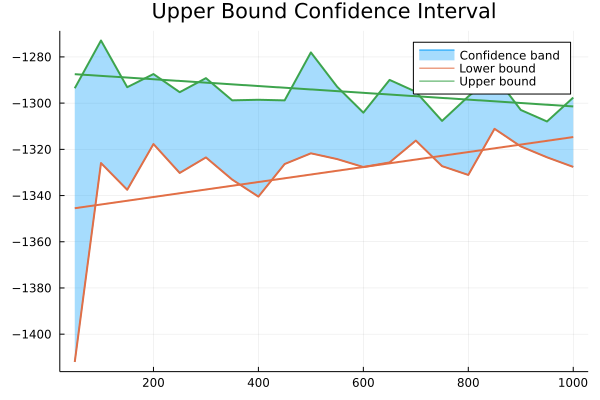

In [5]:
UB_left_Dict = Dict{Float64, Float64}();
UB_right_Dict = Dict{Float64, Float64}();

for Ki in K
    obj_value_list = []
    for i=1:M    
        ξ = rand(50:150,Ki)
        UB_model = Model(Clp.Optimizer)
        set_optimizer_attribute(UB_model, "LogLevel",0)
        @variables(UB_model,begin
            y[1:Ki] ≥ 0
            w[1:Ki] ≥ 0
        end)
        @constraints(UB_model,begin
            ct1[s=1:Ki], y[s] ≤ ξ[s]
            ct2[s=1:Ki], y[s] + w[s] ≤ x_chosen
        end)
        @objective(UB_model, Min, 10*x_chosen + (1/Ki)*sum(-25*y[s] - 5*w[s] for s in 1:Ki))
        optimize!(UB_model)
        append!(obj_value_list, objective_value(UB_model))
    end
    V̄=sum(obj_value_list)/M
    UB_left = V̄ - 1.96*std(obj_value_list)/sqrt(M)
    UB_right = V̄ + 1.96*std(obj_value_list)/sqrt(M)
    push!(UB_left_Dict,Ki =>UB_left)
    push!(UB_right_Dict,Ki =>UB_right)
    println("Confidence Interval for Ki=$(Ki): [$(UB_left),$(UB_right)]")

end

u = x-> UB_right_Dict[x]
plot(x=N,UB_left_Dict, fillrange=u,fillalpha = 0.35,label = "Confidence band", legend = :topright, title = "Upper Bound Confidence Interval")
plot!(x=N,UB_left_Dict, smooth=true, label = "Lower bound",lw = 2)
plot!(x=N,UB_right_Dict, smooth=true, label = "Upper bound",lw = 2)

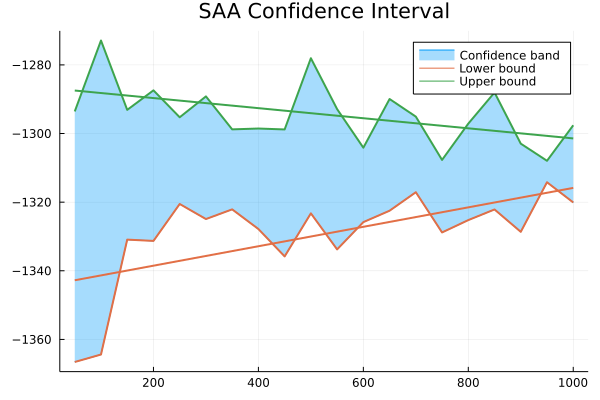

In [6]:
#Plotando o lower bound mais conservador e o Upper Bound mais conservador
u = x-> UB_right_Dict[x]
plot(x=N,LB_left_Dict, fillrange=u,fillalpha = 0.35,label = "Confidence band", legend = :topright, title = "SAA Confidence Interval")
plot!(x=N,LB_left_Dict, smooth=true, label = "Lower bound",lw = 2)
plot!(x=N,UB_right_Dict, smooth=true, label = "Upper bound",lw = 2)